In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
sns.set(font_scale=2, style='ticks')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
vol_file = '../Voltron_data/Voltron_Log_DRN_Exp.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

## Task files

In [3]:
for ind, row in dat_xls_file.iterrows():
    if 'Swimonly' in row['task']:
        print([row['fish'], row['task']])

['Fish2-1-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish2-2-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish3-1-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish3-2-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish3-1-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish3-2-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish4-1-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish4-2-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish5-1-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish5-2-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish6-1-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish6-2-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish7-1-swimonly_visualonly', 'Swimonly_Visualonly']
['Fish7-2-swimonly_visualonly', 'Swimonly_Visualonly']


## Task structure
### rawdata
* stimParam1 : velocity
* stimParam2 : gain
* stimParam3 : task period -- 1, swim-only; 2, visual-only
* stimParam4 : 1, CL; 2, OL, swim-only; 3, replay, visual-only; 0, visual-only, no replay
* stimParam5 : epoch index

In [4]:
# dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
# folder = row['folder']
# fish = row['fish']
# swm_dir = dat_folder+f'{folder}/{fish}/swim/'

# rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
# swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
# t_len = len(rawdata['ch1'])

# plt.figure(figsize=(20, 3))
# plt.plot(np.arange(t_len)/6000, rawdata['stimParam1']*10000, label='visual')
# # plt.plot(np.arange(t_len)/6000, np.sqrt(rawdata['ch1']**2+rawdata['ch2']**2)*30, label='motor')
# plt.plot(np.arange(t_len)/6000, rawdata['ch1']*30, label='motor')
# plt.plot(np.arange(t_len)/6000, rawdata['stimParam4'], label='task type')
# plt.xlim([0, 400])
# plt.show()

## Behavioral data

In [5]:
vol_file = '../Analysis/depreciated/analysis_sections_based_on_swim_pattern_sovo.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

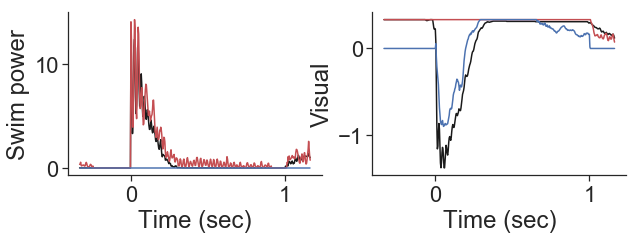

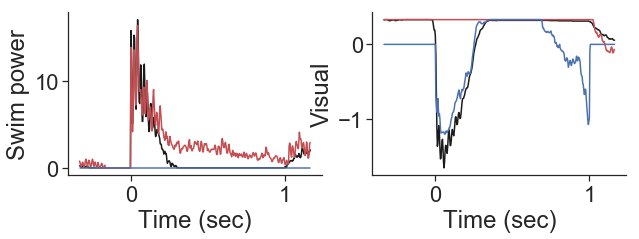

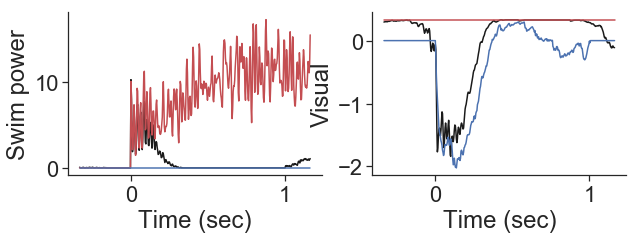

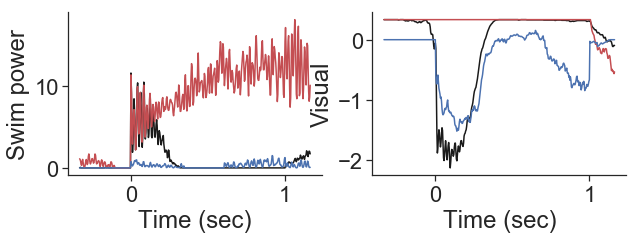

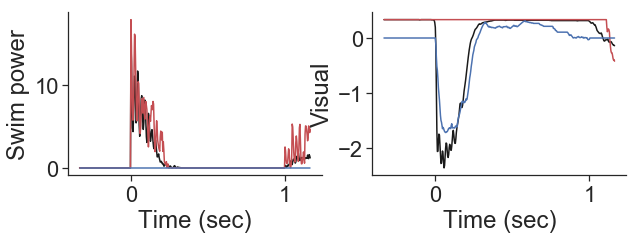

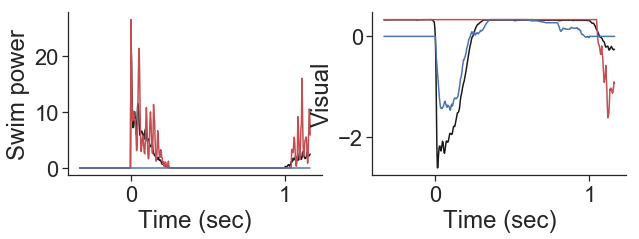

In [92]:
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']
swim_power_thres = 10
t_swim_CL = t_pre + 100

for ind, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
#     if not os.path.exists(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz'):
#         continue
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['swim_task_index'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)
    trial_valid_CL = (p_swim[:, t_swim_CL:t_swim_CL+150]>0).sum(axis=-1)==0
    trial_valid_OL = ((visu.max(axis=-1, keepdims=True)-visu)[:, :-50]>0).sum(axis=-1)==0
    
    task_period = _['swim_task_index'].astype('int')            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    trial_valid = _['trial_valid']
    
    if np.percentile(p_swim[(task_period==1) & trial_valid].mean(axis=0), 95)>swim_power_thres:
        continue

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.flatten()
    
    for n in range(3):
        if n==0:
            trial_valid_ = trial_valid & trial_valid_CL
        if n==1:
            trial_valid_ = trial_valid & trial_valid_OL
        if n==2:
            trial_valid_ = trial_valid
        ax[0].plot(t_label, p_swim[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        ax[1].plot(t_label, visu[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('Swim power')
    ax[1].set_xlabel('Time (sec)')
    ax[1].set_ylabel('Visual')
    sns.despine()
    plt.show()

## Subthreshold activity

### Single cells

In [75]:
from scipy.stats import sem

In [76]:
k_ = gaussKernel(sigma=3)
# k_ = boxcarKernel(sigma=5)

In [88]:
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
swim_power_thres = 10
t_label = np.arange(-t_pre, t_post)/300
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']
sub_ave = []
spk_ave = []
is_plot = False

for ind, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
#     if not os.path.exists(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz'):
#         continue    
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    task_period = _['swim_task_index'].astype('int')            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    trial_valid = _['trial_valid']
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['swim_task_index'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)
    trial_valid_CL = (p_swim[:, t_swim_CL:t_swim_CL+150]>0).sum(axis=-1)==0
    trial_valid_OL = ((visu.max(axis=-1, keepdims=True)-visu)[:, :-50]>0).sum(axis=-1)==0
    
    if np.percentile(p_swim[(task_period==1) & trial_valid].mean(axis=0), 95)>swim_power_thres:
        continue
#     # print number of trials
#     print(ind)
#     for n in range(3):    
#         print((trial_valid & (task_period==n+1)).sum())
#     print('\n')
    for n_cell in range(sub_swim.shape[0]):
        sub_list = sub_swim[n_cell]
        # sub_list = sub_list - sub_list[:, 0:70].mean(axis=-1, keepdims=True) # (t_pre-30):t_pre
        sub_list = sub_list - sub_list[:, (t_pre-30):t_pre].mean(axis=-1, keepdims=True)
        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        
        if is_plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 3))
            ax = ax.flatten()
            
        tmp1 = []
        tmp2 = []
        for n in range(3):
            if n==0:
                trial_valid_ = trial_valid & trial_valid_CL
            if n==1:
                trial_valid_ = trial_valid & trial_valid_OL
            if n==2:
                trial_valid_ = trial_valid
            ave_ = sub_list[(task_period==n+1) & trial_valid_, :]*100
            mean_ = np.mean(ave_, axis=0)
            std_ = sem(ave_, axis=0, nan_policy='omit')
            if is_plot:
                ax[0].plot(t_label, mean_, f'-{c_list[n]}', lw=2)
                ax[0].plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
                ax[0].plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
                ax[0].set_xlim([-t_pre/300, t_post/300])
                ax[0].set_xlabel('Time (sec)')
                ax[0].set_ylabel('dF/F')
                sns.despine()
            tmp1.append(mean_)
            
            ave_ = spk_list[(task_period==n+1) & trial_valid_, :]*300
            mean_ = np.mean(ave_, axis=0)
            std_ = sem(ave_, axis=0, nan_policy='omit')
            if is_plot:
                ax[1].plot(t_label, mean_, f'-{c_list[n]}', lw=2, label=labels[n])
                ax[1].plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
                ax[1].plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
                ax[1].set_xlim([-t_pre/300, t_post/300])
                ax[1].set_xlabel('Time (sec)')
                ax[1].set_ylabel('Spikes')
                sns.despine()
                # ax[1].legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=3)
            tmp2.append(mean_)
        sub_ave.append(np.array(tmp1))
        spk_ave.append(np.array(tmp2))
        
        if is_plot:
            plt.show()

In [89]:
sub_ave = np.array(sub_ave)
spk_ave = np.array(spk_ave)
print(f'number of cells {sub_ave.shape[0]}')

number of cells 26


In [90]:
# from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# for n_cell in range(spk_ave.shape[0]):
#     X = spk_ave[n_cell][1:]
#     y = spk_ave[n_cell][0]
#     reg.fit(X.T, y.T)
#     y_ = reg.predict(X.T)
#     print(reg.score(X.T, y.T))
#     plt.plot(X[0], label='swim-only')
#     plt.plot(X[1], label='visual-only')
#     plt.plot(y, label='CL')
#     plt.plot(y_, label='Linear model')
#     plt.legend()
#     plt.show()

### Cell average

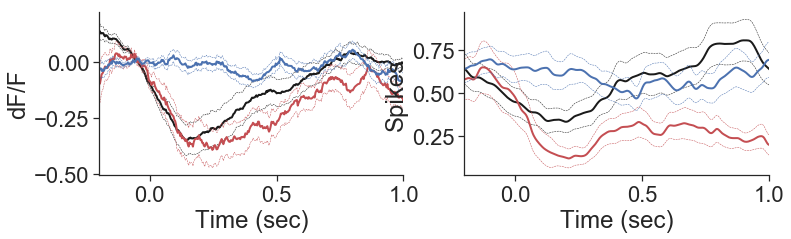

In [91]:
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
for n in range(3):
    ave_ = sub_ave[:, n, :]
    mean_ = np.mean(ave_, axis=0)
    std_ = sem(ave_, axis=0, nan_policy='omit')
    ax[0].plot(t_label, mean_, f'-{c_list[n]}', lw=2)
    ax[0].plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
    ax[0].plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
    # ax[0].set_xlim([-t_pre/300, t_post/300])
    ax[0].set_xlim([-0.2, 1])
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('dF/F')
    sns.despine()

    ave_ = spk_ave[:, n, :]
    mean_ = np.mean(ave_, axis=0)
    std_ = sem(ave_, axis=0, nan_policy='omit')
    ax[1].plot(t_label, mean_, f'-{c_list[n]}', lw=2, label=labels[n])
    ax[1].plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
    ax[1].plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
    # ax[1].set_xlim([-t_pre/300, t_post/300])
    ax[1].set_xlim([-0.2, 1])
    ax[1].set_xlabel('Time (sec)')
    ax[1].set_ylabel('Spikes')
    sns.despine()
plt.show()

In [55]:
# plt.figure(figsize=(5, 30))
# plt.plot(spk_ave[:, 2, :].T+np.arange(0, spk_ave.shape[0]*2, 2))
# plt.show()